# Binary-Class Tabular Model for Rice Cammeo Osmancik Identification Using Python and TensorFlow Decision Forests
### David Lowe
### May 3, 2022

SUMMARY: The project aims to construct a predictive model using various machine learning algorithms and document the end-to-end steps using a template. The Rice Cammeo Osmancik Identification dataset is a binary-class modeling situation where we attempt to predict one of two possible outcomes.

INTRODUCTION: Rice is one of the most widely produced and consumed cereal crops globally. The crop is also the main sustenance for many countries because of its economic and nutritious nature. However, before rice reaches the consumers, it must go through many manufacturing steps such as cleaning, color sorting, and classification. In this study, the research team developed a computerized vision system to classify two proprietary rice species. The dataset contains the measurements for 3,810 rice grain images. The grain image broke down into seven major morphological features for each grain of rice.

ANALYSIS: The performance of the preliminary Random Forest model achieved an accuracy benchmark of 96.73% on the training dataset. When we applied the finalized model to the test dataset, the model achieved an accuracy score of 92.65%.

CONCLUSION: In this iteration, the TensorFlow Decision Forests model appeared to be suitable for modeling this dataset.

Dataset Used: Rice Dataset Cammeo and Osmancik

Dataset ML Model: Binary classification with numerical features

Dataset Reference: https://www.muratkoklu.com/datasets/

One source of potential performance benchmarks: https://doi.org/10.18201/ijisae.2019355381

## Task 1 - Prepare Environment

In [1]:
# Retrieve the CPU information
ncpu = !nproc
print("The number of available CPUs is:", ncpu[0])

The number of available CPUs is: 2


### 1.a) Load libraries and modules

In [2]:
# Set the random seed number for reproducible results
RNG_SEED = 888

In [3]:
import random
random.seed(RNG_SEED)
import numpy as np
np.random.seed(RNG_SEED)
import pandas as pd
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
import os
import sys
import math
from datetime import datetime
# import boto3
# from dotenv import load_dotenv
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.model_selection import RepeatedKFold
from sklearn.pipeline import Pipeline
from sklearn import compose
from sklearn import impute
from sklearn import metrics
import tensorflow as tf
tf.random.set_seed(RNG_SEED)
# from tensorflow import keras
import tensorflow_decision_forests as tfdf

### 1.b) Set up the controlling parameters and functions

In [4]:
# Begin the timer for the script processing
start_time_script = datetime.now()

# Set up the number of CPU cores available for multi-thread processing
N_JOBS = 1

# Set up the flag to stop sending progress emails (setting to True will send status emails!)
NOTIFY_STATUS = False

# Set the percentage sizes for splitting the dataset
TEST_SET_RATIO = 0.1
VAL_SET_RATIO = 0.1

# Set the number of folds for cross validation
N_FOLDS = 5
N_ITERATIONS = 1

# Set various default modeling parameters
DEFAULT_METRICS = ["accuracy", tf.keras.metrics.AUC()]

# # Check the number of GPUs accessible through TensorFlow
# print('Num GPUs Available:', len(tf.config.list_physical_devices('GPU')))

# Print out the TensorFlow version for confirmation
print('TensorFlow version:', tf.__version__)

# Check the version of TensorFlow Decision Forests
print("Found TensorFlow Decision Forests v" + tfdf.__version__)

TensorFlow version: 2.8.0
Found TensorFlow Decision Forests v0.2.4


In [5]:
# Set up the email notification function
def status_notify(msg_text):
    access_key = os.environ.get('SNS_ACCESS_KEY')
    secret_key = os.environ.get('SNS_SECRET_KEY')
    aws_region = os.environ.get('SNS_AWS_REGION')
    topic_arn = os.environ.get('SNS_TOPIC_ARN')
    if (access_key is None) or (secret_key is None) or (aws_region is None):
        sys.exit("Incomplete notification setup info. Script Processing Aborted!!!")
    sns = boto3.client('sns', aws_access_key_id=access_key, aws_secret_access_key=secret_key, region_name=aws_region)
    response = sns.publish(TopicArn=topic_arn, Message=msg_text)
    if response['ResponseMetadata']['HTTPStatusCode'] != 200 :
        print('Status notification not OK with HTTP status code:', response['ResponseMetadata']['HTTPStatusCode'])

In [6]:
# Reset the random number generators
def reset_random(x=RNG_SEED):
    random.seed(x)
    np.random.seed(x)
    tf.random.set_seed(x)

In [7]:
if NOTIFY_STATUS: status_notify("Task 1 - Prepare Environment has begun! " + datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

### 1.c) Load dataset

In [8]:
dataset_path = 'https://dainesanalytics.com/datasets/muratkoklu-rice-cammeo-osmancik/Rice_Cammeo_Osmancik.arff'
colNames = ['Area','Perimeter','Major_Axis_Length','Minor_Axis_Length','Eccentricity','Convex_Area','Extent','Class']
df_dataset_import = pd.read_csv(dataset_path, names=colNames, sep=',', header=None, index_col=False, skiprows=16)

# Take a peek at the dataframe after import
print(df_dataset_import.head())

    Area   Perimeter  Major_Axis_Length  Minor_Axis_Length  Eccentricity  \
0  15231  525.578979         229.749878          85.093788      0.928882   
1  14656  494.311005         206.020065          91.730972      0.895405   
2  14634  501.122009         214.106781          87.768288      0.912118   
3  13176  458.342987         193.337387          87.448395      0.891861   
4  14688  507.166992         211.743378          89.312454      0.906691   

   Convex_Area    Extent   Class  
0        15617  0.572896  Cammeo  
1        15072  0.615436  Cammeo  
2        14954  0.693259  Cammeo  
3        13368  0.640669  Cammeo  
4        15262  0.646024  Cammeo  


In [9]:
df_dataset_import.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3810 entries, 0 to 3809
Data columns (total 8 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Area               3810 non-null   int64  
 1   Perimeter          3810 non-null   float64
 2   Major_Axis_Length  3810 non-null   float64
 3   Minor_Axis_Length  3810 non-null   float64
 4   Eccentricity       3810 non-null   float64
 5   Convex_Area        3810 non-null   int64  
 6   Extent             3810 non-null   float64
 7   Class              3810 non-null   object 
dtypes: float64(5), int64(2), object(1)
memory usage: 238.2+ KB


In [10]:
print(df_dataset_import.describe())

               Area    Perimeter  Major_Axis_Length  Minor_Axis_Length  \
count   3810.000000  3810.000000        3810.000000        3810.000000   
mean   12667.727559   454.239180         188.776222          86.313750   
std     1732.367706    35.597081          17.448679           5.729817   
min     7551.000000   359.100006         145.264465          59.532406   
25%    11370.500000   426.144753         174.353855          82.731695   
50%    12421.500000   448.852493         185.810059          86.434647   
75%    13950.000000   483.683746         203.550438          90.143677   
max    18913.000000   548.445984         239.010498         107.542450   

       Eccentricity   Convex_Area       Extent  
count   3810.000000   3810.000000  3810.000000  
mean       0.886871  12952.496850     0.661934  
std        0.020818   1776.972042     0.077239  
min        0.777233   7723.000000     0.497413  
25%        0.872402  11626.250000     0.598862  
50%        0.889050  12706.500000     0

In [11]:
print(df_dataset_import.isnull().sum())
print('Total number of NaN in the dataframe: ', df_dataset_import.isnull().sum().sum())

Area                 0
Perimeter            0
Major_Axis_Length    0
Minor_Axis_Length    0
Eccentricity         0
Convex_Area          0
Extent               0
Class                0
dtype: int64
Total number of NaN in the dataframe:  0


In [12]:
# Get grouping size for the target variable
print(df_dataset_import.groupby('Class').size())

Class
Cammeo      1630
Osmancik    2180
dtype: int64


### 1.d) Data Cleaning

In [13]:
# Standardize the class column to the name of targetVar if required
df_dataset_import = df_dataset_import.rename(columns={'Class': 'target'})

# Take a peek at the dataframe after cleaning
print(df_dataset_import.head())

    Area   Perimeter  Major_Axis_Length  Minor_Axis_Length  Eccentricity  \
0  15231  525.578979         229.749878          85.093788      0.928882   
1  14656  494.311005         206.020065          91.730972      0.895405   
2  14634  501.122009         214.106781          87.768288      0.912118   
3  13176  458.342987         193.337387          87.448395      0.891861   
4  14688  507.166992         211.743378          89.312454      0.906691   

   Convex_Area    Extent  target  
0        15617  0.572896  Cammeo  
1        15072  0.615436  Cammeo  
2        14954  0.693259  Cammeo  
3        13368  0.640669  Cammeo  
4        15262  0.646024  Cammeo  


In [14]:
df_dataset_import.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3810 entries, 0 to 3809
Data columns (total 8 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Area               3810 non-null   int64  
 1   Perimeter          3810 non-null   float64
 2   Major_Axis_Length  3810 non-null   float64
 3   Minor_Axis_Length  3810 non-null   float64
 4   Eccentricity       3810 non-null   float64
 5   Convex_Area        3810 non-null   int64  
 6   Extent             3810 non-null   float64
 7   target             3810 non-null   object 
dtypes: float64(5), int64(2), object(1)
memory usage: 238.2+ KB


In [15]:
print(df_dataset_import.describe())

               Area    Perimeter  Major_Axis_Length  Minor_Axis_Length  \
count   3810.000000  3810.000000        3810.000000        3810.000000   
mean   12667.727559   454.239180         188.776222          86.313750   
std     1732.367706    35.597081          17.448679           5.729817   
min     7551.000000   359.100006         145.264465          59.532406   
25%    11370.500000   426.144753         174.353855          82.731695   
50%    12421.500000   448.852493         185.810059          86.434647   
75%    13950.000000   483.683746         203.550438          90.143677   
max    18913.000000   548.445984         239.010498         107.542450   

       Eccentricity   Convex_Area       Extent  
count   3810.000000   3810.000000  3810.000000  
mean       0.886871  12952.496850     0.661934  
std        0.020818   1776.972042     0.077239  
min        0.777233   7723.000000     0.497413  
25%        0.872402  11626.250000     0.598862  
50%        0.889050  12706.500000     0

In [16]:
print(df_dataset_import.isnull().sum())
print('Total number of NaN in the dataframe: ', df_dataset_import.isnull().sum().sum())

Area                 0
Perimeter            0
Major_Axis_Length    0
Minor_Axis_Length    0
Eccentricity         0
Convex_Area          0
Extent               0
target               0
dtype: int64
Total number of NaN in the dataframe:  0


In [17]:
# Get grouping size for the target variable
print(df_dataset_import.groupby('target').size())

target
Cammeo      1630
Osmancik    2180
dtype: int64


### 1.e) Splitting Data into Sets

In [18]:
# Split the data further into training and test datasets
df_dataset_train, df_dataset_test = train_test_split(df_dataset_import, test_size=TEST_SET_RATIO, random_state=RNG_SEED,
                                                     stratify=df_dataset_import['target'])
print("df_dataset_train.shape: {} df_dataset_test.shape: {}".format(df_dataset_train.shape, df_dataset_test.shape))

df_dataset_train.shape: (3429, 8) df_dataset_test.shape: (381, 8)


In [19]:
# Use variable total_column_count to hold the number of columns in the dataframe
total_column_count = len(df_dataset_import.columns)

# Set up variable total_feature_count for the total number of attribute columns
total_feature_count = total_column_count-1

# We create attribute-only and target-only datasets (df_features_train and df_target_train)
df_target_train = df_dataset_train['target']
df_features_train = df_dataset_train.drop(['target'], axis=1)

print("df_dataset_train.shape: {} df_features_train.shape: {} df_target_train.shape: {}".format(df_dataset_train.shape, df_features_train.shape, df_target_train.shape))

df_dataset_train.shape: (3429, 8) df_features_train.shape: (3429, 7) df_target_train.shape: (3429,)


### 1.f) Set up the parameters for data visualization

In [20]:
# Set up the number of row and columns for visualization display. display_rows * display_columns should be >= total_feature_count
display_columns = 4
if total_feature_count % display_columns == 0 :
    display_rows = total_feature_count // display_columns
else :
    display_rows = (total_feature_count // display_columns) + 1
    
# Set figure width to display the data visualization plots
fig_size = plt.rcParams["figure.figsize"]
fig_size[0] = display_columns * 4
fig_size[1] = display_rows * 4
plt.rcParams["figure.figsize"] = fig_size

In [21]:
if NOTIFY_STATUS: status_notify("Task 1 - Prepare Environment completed! "+datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

## Task 2 - Summarize and Visualize Data

In [22]:
if NOTIFY_STATUS: status_notify("Task 2 - Summarize and Visualize Data has begun! "+datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

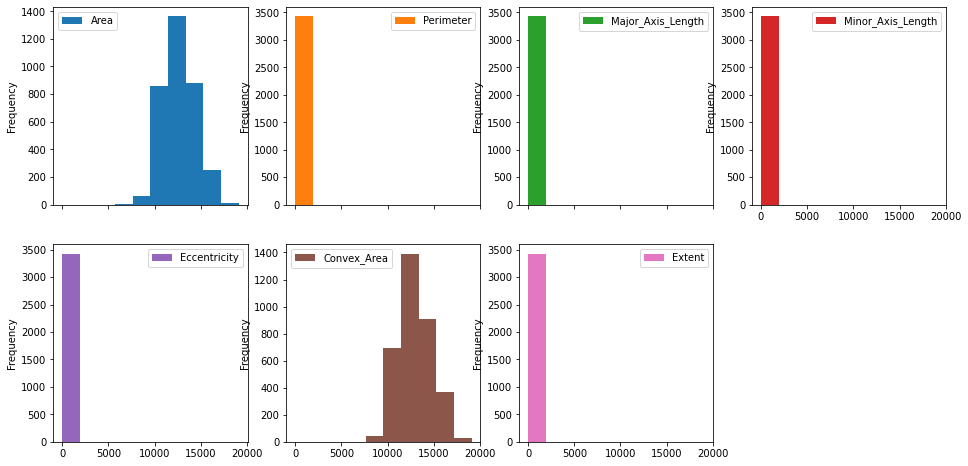

In [23]:
# Histograms for each attribute
df_features_train.plot(kind='hist', subplots=True, layout=(display_rows, display_columns))
plt.show()

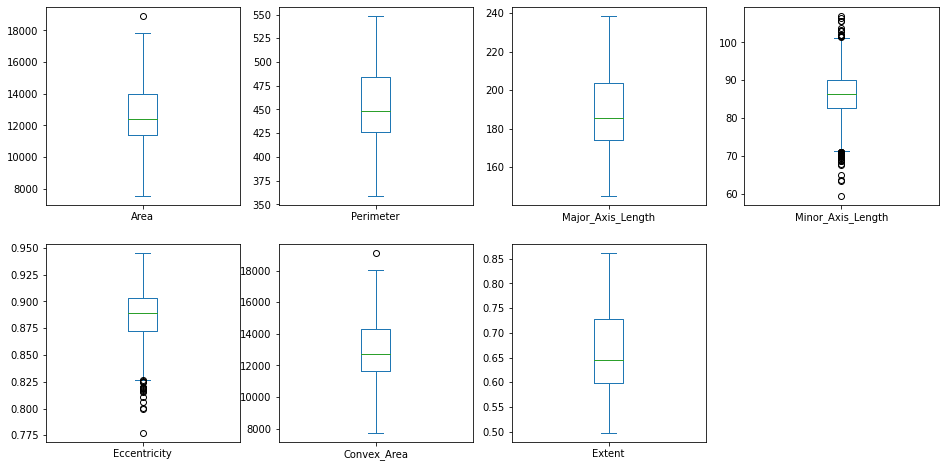

In [24]:
# Box and Whisker plot for each attribute
df_features_train.plot(kind='box', subplots=True, layout=(display_rows, display_columns))
plt.show()

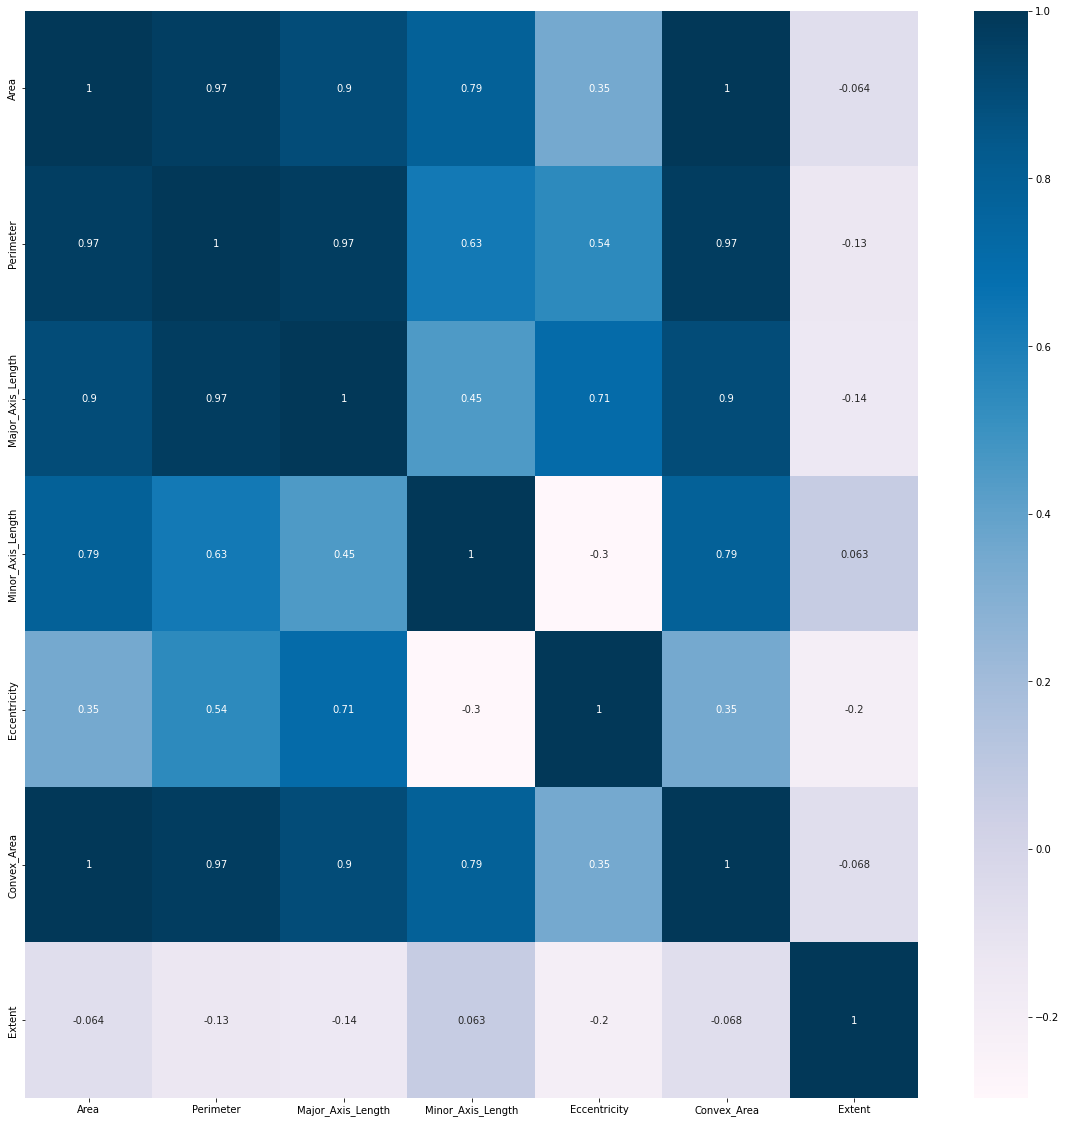

In [25]:
# Correlation matrix
fig = plt.figure(figsize=(20, 20))
correlations = df_features_train.corr(method='pearson')
sns.heatmap(correlations, annot=True, cmap=plt.cm.PuBu)
plt.show()

In [26]:
if NOTIFY_STATUS: status_notify("Task 2 - Summarize and Visualize Data completed! "+datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

## Task 3 - Train and Evaluate Models

In [27]:
if NOTIFY_STATUS: status_notify("Task 3 - Train and Evaluate Models has begun! "+datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

### 3.a) Splitting Data into Training and Validation Sets

In [28]:
# Finalize the training and validation datasets for the modeling activities
tfds_train = tfdf.keras.pd_dataframe_to_tf_dataset(df_dataset_train, label='target', task = tfdf.keras.Task.CLASSIFICATION)

/usr/local/lib/python3.7/dist-packages/tensorflow_decision_forests/keras/core.py:2036: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  features_dataframe = dataframe.drop(label, 1)


### 3.b) Train and Evaluate the Random Forest Model

In [29]:
# Define the baseline model for benchmarking
start_time_module = datetime.now()
reset_random()
RF_model = tfdf.keras.RandomForestModel(task = tfdf.keras.Task.CLASSIFICATION)
RF_model.compile(metrics=DEFAULT_METRICS)

# "sys_pipes" is optional. It enables the display of the training logs.
# with sys_pipes():
#     RF_model.fit(x=tfds_train)

# Train the model.
RF_model.fit(x=tfds_train)
print ('Model training time:', (datetime.now() - start_time_module), '\n')

Use /tmp/tmph10ulurn as temporary training directory
Starting reading the dataset
1/4 [======>.......................] - ETA: 28s
Dataset read in 0:00:09.541588
Training model
Model trained in 0:00:02.211026
Compiling model
4/4 [==============================] - 12s 836ms/step
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: could not get source code
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: could not get source code
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: could not get source code
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Model training time: 0:00:14.460762 



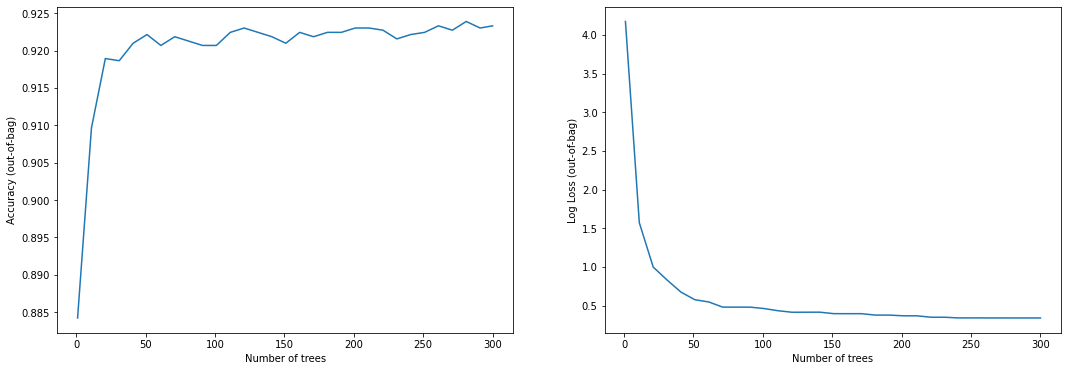

In [30]:
logs = RF_model.make_inspector().training_logs()

plt.figure(figsize=(18, 6))
plt.subplot(1, 2, 1)
plt.plot([log.num_trees for log in logs], [log.evaluation.accuracy for log in logs])
plt.xlabel("Number of trees")
plt.ylabel("Accuracy (out-of-bag)")
plt.subplot(1, 2, 2)
plt.plot([log.num_trees for log in logs], [log.evaluation.loss for log in logs])
plt.xlabel("Number of trees")
plt.ylabel("Log Loss (out-of-bag)")
plt.show()

In [31]:
RF_eval = RF_model.evaluate(tfds_train, return_dict=True)
print()

for name, value in RF_eval.items():
    print(f"{name}: {value:.4f}")

4/4 [==============================] - 1s 21ms/step - loss: 0.0000e+00 - accuracy: 0.9673 - auc: 0.9971

loss: 0.0000
accuracy: 0.9673
auc: 0.9971


### 3.c) Train and Evaluate the Decision Trees Model

In [32]:
# Define the baseline model for benchmarking
start_time_module = datetime.now()
reset_random()
CART_model = tfdf.keras.CartModel(task = tfdf.keras.Task.CLASSIFICATION)
CART_model.compile(metrics=DEFAULT_METRICS)

# "sys_pipes" is optional. It enables the display of the training logs.
# with sys_pipes():
#     CART_model.fit(x=tfds_train)

# Train the model.
CART_model.fit(x=tfds_train)
print ('Model training time:', (datetime.now() - start_time_module), '\n')

Use /tmp/tmp78bf_is7 as temporary training directory
Starting reading the dataset
1/4 [======>.......................] - ETA: 0s
Dataset read in 0:00:00.128769
Training model
Model trained in 0:00:00.011415
Compiling model
4/4 [==============================] - 0s 13ms/step
Model training time: 0:00:00.275233 



In [33]:
CART_eval = CART_model.evaluate(tfds_train, return_dict=True)
print()

for name, value in CART_eval.items():
    print(f"{name}: {value:.4f}")

4/4 [==============================] - 0s 7ms/step - loss: 0.0000e+00 - accuracy: 0.9373 - auc: 0.9853

loss: 0.0000
accuracy: 0.9373
auc: 0.9853


### 3.d) Train and Evaluate the Gradient Boosted Trees Model

In [34]:
# Define the baseline model for benchmarking
start_time_module = datetime.now()
reset_random()
GBT_model = tfdf.keras.GradientBoostedTreesModel(task = tfdf.keras.Task.CLASSIFICATION)
GBT_model.compile(metrics=DEFAULT_METRICS)

# "sys_pipes" is optional. It enables the display of the training logs.
# with sys_pipes():
#     GBT_model.fit(x=tfds_train)

# Train the model.
GBT_model.fit(x=tfds_train)
print ('Model training time:', (datetime.now() - start_time_module), '\n')

Use /tmp/tmp6zdss4vd as temporary training directory
Starting reading the dataset
1/4 [======>.......................] - ETA: 0s
Dataset read in 0:00:00.141162
Training model
Model trained in 0:00:00.752198
Compiling model
4/4 [==============================] - 1s 260ms/step
Model training time: 0:00:01.508380 



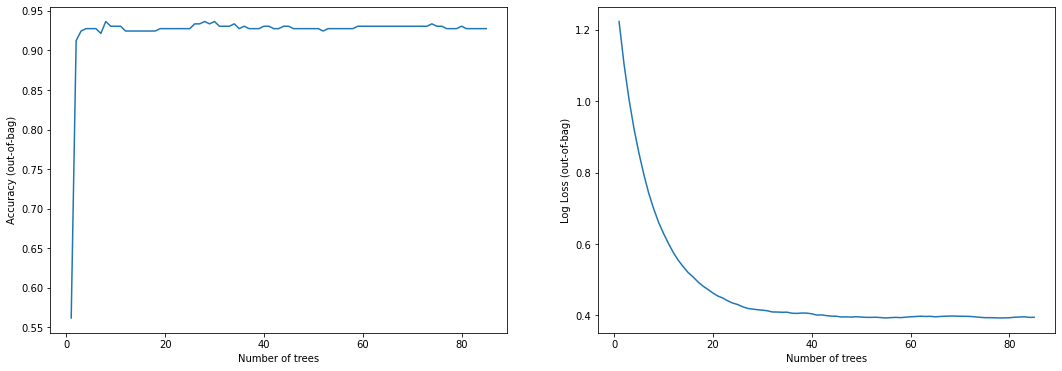

In [35]:
logs = GBT_model.make_inspector().training_logs()

plt.figure(figsize=(18, 6))
plt.subplot(1, 2, 1)
plt.plot([log.num_trees for log in logs], [log.evaluation.accuracy for log in logs])
plt.xlabel("Number of trees")
plt.ylabel("Accuracy (out-of-bag)")
plt.subplot(1, 2, 2)
plt.plot([log.num_trees for log in logs], [log.evaluation.loss for log in logs])
plt.xlabel("Number of trees")
plt.ylabel("Log Loss (out-of-bag)")
plt.show()

In [36]:
GBT_eval = GBT_model.evaluate(tfds_train, return_dict=True)
print()

for name, value in GBT_eval.items():
    print(f"{name}: {value:.4f}")

4/4 [==============================] - 0s 5ms/step - loss: 0.0000e+00 - accuracy: 0.9551 - auc: 0.9883

loss: 0.0000
accuracy: 0.9551
auc: 0.9883


In [37]:
if NOTIFY_STATUS: status_notify("Task 4 - Train and Evaluate Models completed! "+datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

## Task 4 - Fine-tune and Improve Models

In [38]:
if NOTIFY_STATUS: status_notify("Task 4 - Fine-tune and Improve Models has begun! "+datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

In [39]:
# Not applicable for this iteration of modeling

In [40]:
if NOTIFY_STATUS: status_notify("Task 4 - Fine-tune and Improve Models completed! "+datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

## Task 5 - Finalize Model and Present Analysis

In [41]:
if NOTIFY_STATUS: status_notify("Task 5 - Finalize Model and Present Analysis has begun! "+datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

### 5.a) Train the Final Model

In [42]:
# Define the baseline model for benchmarking
start_time_module = datetime.now()
reset_random()
Final_model = tfdf.keras.RandomForestModel(task = tfdf.keras.Task.CLASSIFICATION)

# Optionally, add evaluation metrics.
Final_model.compile(metrics=DEFAULT_METRICS)

# "sys_pipes" is optional. It enables the display of the training logs.
# with sys_pipes():
#     Final_model.fit(x=tfds_train)

# Train the model.
Final_model.fit(x=tfds_train)
print ('Model training time:', (datetime.now() - start_time_module), '\n')

Use /tmp/tmpc7dpjn7_ as temporary training directory
Starting reading the dataset
1/4 [======>.......................] - ETA: 0s
Dataset read in 0:00:00.130301
Training model
Model trained in 0:00:01.148318
Compiling model
4/4 [==============================] - 1s 435ms/step
Model training time: 0:00:02.794413 



In [43]:
Final_model.summary()

Model: "random_forest_model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
Total params: 1
Trainable params: 0
Non-trainable params: 1
_________________________________________________________________
Type: "RANDOM_FOREST"
Task: CLASSIFICATION
Label: "__LABEL"

Input Features (7):
	Area
	Convex_Area
	Eccentricity
	Extent
	Major_Axis_Length
	Minor_Axis_Length
	Perimeter

No weights

Variable Importance: MEAN_MIN_DEPTH:
    1.           "__LABEL"  8.847744 ################
    2. "Minor_Axis_Length"  6.543729 ###########
    3.            "Extent"  6.350152 ##########
    4.              "Area"  6.281004 ##########
    5.       "Convex_Area"  5.697264 #########
    6.      "Eccentricity"  5.145903 ########
    7.         "Perimeter"  2.201945 ##
    8. "Major_Axis_Length"  1.084952 

Variable Importance: NUM_AS_ROOT:
    1. "Major_Axis_Length" 157.000000 ################
    2.         "Perimeter" 102

### 5.b) Load Test Dataset and Make Predictions

In [44]:
# Finalize the test dataset for the prediction activities
tfds_test = tfdf.keras.pd_dataframe_to_tf_dataset(df_dataset_test, label='target', task = tfdf.keras.Task.CLASSIFICATION)

/usr/local/lib/python3.7/dist-packages/tensorflow_decision_forests/keras/core.py:2036: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  features_dataframe = dataframe.drop(label, 1)


In [45]:
Final_eval = Final_model.evaluate(tfds_test, return_dict=True)
print()

for name, value in Final_eval.items():
    print(f"{name}: {value:.4f}")

1/1 [==============================] - 0s 319ms/step - loss: 0.0000e+00 - accuracy: 0.9265 - auc: 0.9877

loss: 0.0000
accuracy: 0.9265
auc: 0.9877


In [46]:
if NOTIFY_STATUS: status_notify("Task 5 - Finalize Model and Present Analysis completed! "+datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

In [47]:
print ('Total time for the script:',(datetime.now() - start_time_script))

Total time for the script: 0:00:27.221539
